# Tests

- Different images - jittering, L1 loss, same image init, 2x subsampling
- Different subsampling factors (2x, 4x, 6x) - jittering, L1 loss, same image init


- Different network initializations (Same image, Diff image, No init), jittering, 2x subsampling - L1 vs L2 loss
    - L1: Same image slightly better than diff image slightly better than no init
    - L2: Same image and diff image similar, no init worse
- Different loss functions (L1, L2, Linf), jittering, 2x subsampling - Same image init vs no init
    - Same image init & no init: L1 and L2 similar, Linf worse
- DIfferent jittering schedules (0, 0.1 const, 0.01 const, 0.1/0.01 decay) - jittering, L1 loss, same image init
    - 0.1/0.01 decay marginally best
- Different networks (3 blocks, 4 blocks, 5 blocks) - jittering, L1 loss, no init
    - 3 blocks and 4 blocks similar, 5 blocks worse

# Todo
- Conv layer visualization
- Comparison to wavelet reconstruction 

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import sys
sys.path.insert(0, '../')
from utils import *


In [4]:
def get_image_normalized(index, plot=False):
    data = glob("../data/test_img_slices/*.ra")
    img = get_image_old2('../data/test_img_slices/19_{}.ra'.format(index)) # same - for linux
    minv = np.min(img[:, :, 0])
    maxv = np.max(img[:, :, 0])
    normalized_img = np.expand_dims(-1 + (2 * (np.array(img[:, :, 0] - minv) / (maxv - minv))), 2)
    if plot:
        plt.imshow(normalized_img[:, :, 0], cmap='gray')
        plt.show()
    minv = np.min(normalized_img[:, :, 0])
    maxv = np.max(normalized_img[:, :, 0])
    #print(minv, maxv)
    return normalized_img


def get_subsampled_normalized(normalized_img, subs, plot=False):
    mask_files = glob("../masks/gen_masks/{}_0*".format(subs))
    mask_files = [np.fft.fftshift(np.load(m)) for m in mask_files]
    mask = mask_files[0]
    new_img = np.fft.ifft2(np.multiply(np.fft.fft2(normalized_img[:, :, 0]), mask)).astype(float)
    minv = np.min(new_img)
    maxv = np.max(new_img)
    normalized_new_img = np.expand_dims(-1 + (2 * (new_img - minv) / (maxv - minv)), 2)
    if plot:
        plt.imshow(normalized_new_img[:, :, 0], cmap='gray')
        plt.show()
    #print(np.min(normalized_new_img))
    #print(np.max(normalized_new_img))
    return normalized_new_img

In [5]:
orig_img = get_image_normalized(100, plot=False)
subs_img = get_subsampled_normalized(orig_img, 2, plot=False)
subs_img_4 = get_subsampled_normalized(orig_img, 4, plot=False)
subs_img_6 = get_subsampled_normalized(orig_img, 6, plot=False)

c:\users\jains\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part


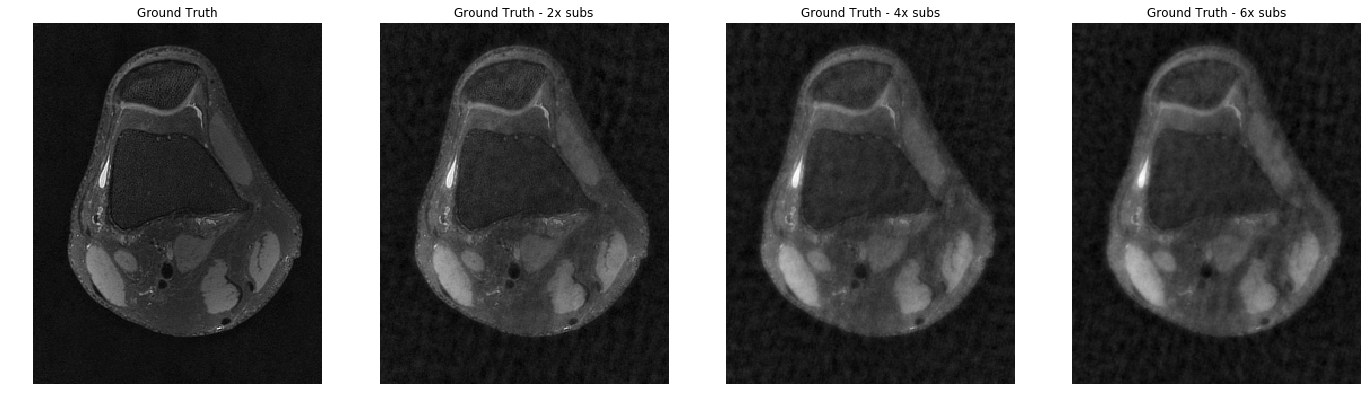

Reconstructions:
Trial 0


NameError: name 'get_best_L2' is not defined

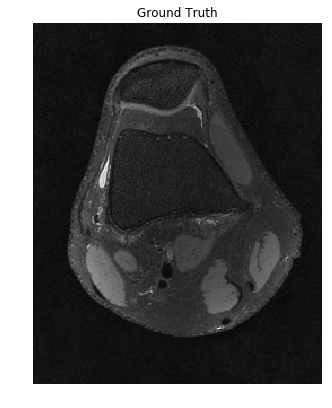

In [6]:
# compare L1 loss, same image init, jitters, 2x vs 4x vs 6x subsampling recon

all_results = np.load('../deep_prior_data/comparisons/diff_masks_L1.npy')
trials = 3
titles = ['recon 2x subsampling mask', 'recon 4x subsampling mask', 'recon 6x subsampling mask']
plt.figure(figsize=(30,10))
plt.subplot(151); plt.axis('off'); plt.title('Ground Truth'); plt.imshow(orig_img[:, :, 0], cmap='gray')
plt.subplot(152); plt.axis('off'); plt.title('Ground Truth - 2x subs'); plt.imshow(subs_img[:, :, 0], cmap='gray')
plt.subplot(153); plt.axis('off'); plt.title('Ground Truth - 4x subs'); plt.imshow(subs_img_4[:, :, 0], cmap='gray')
plt.subplot(154); plt.axis('off'); plt.title('Ground Truth - 6x subs'); plt.imshow(subs_img_6[:, :, 0], cmap='gray')
plt.show()
print('Reconstructions:')
for i in range(trials): # did 3 different noise values
    curr_L1 = []
    curr_L2 = []
    plt.figure(figsize=(30,10))
    plt.subplot(151); plt.axis('off'); plt.title('Ground Truth'); plt.imshow(orig_img[:, :, 0], cmap='gray')
    print('Trial {}'.format(i))
    for j in range(3): # tested 3 diff masks
        curr = all_results[j][i]
        best, ind = get_best_L2(curr[0], orig_img)
        plt.subplot(152 + j); plt.axis('off'); plt.title(titles[j]); plt.imshow(best[:, :, 0], cmap='gray')
        curr_L1.append(curr[1][0][ind])
        curr_L2.append(curr[1][1][ind])
    plt.show()
    print('L1 errors: ', curr_L1)
    print('L2 errors: ', curr_L2)

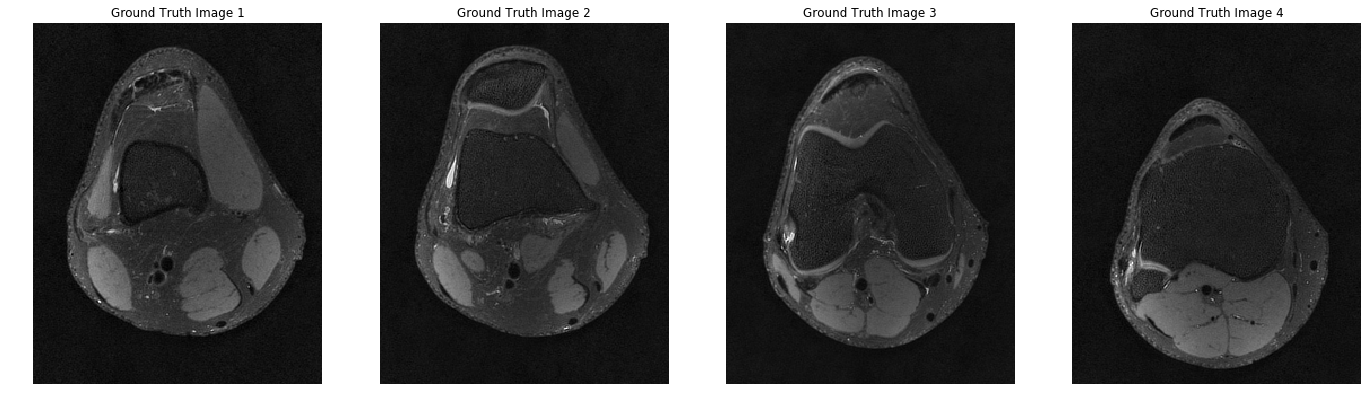

Reconstructions: 
Trial 0


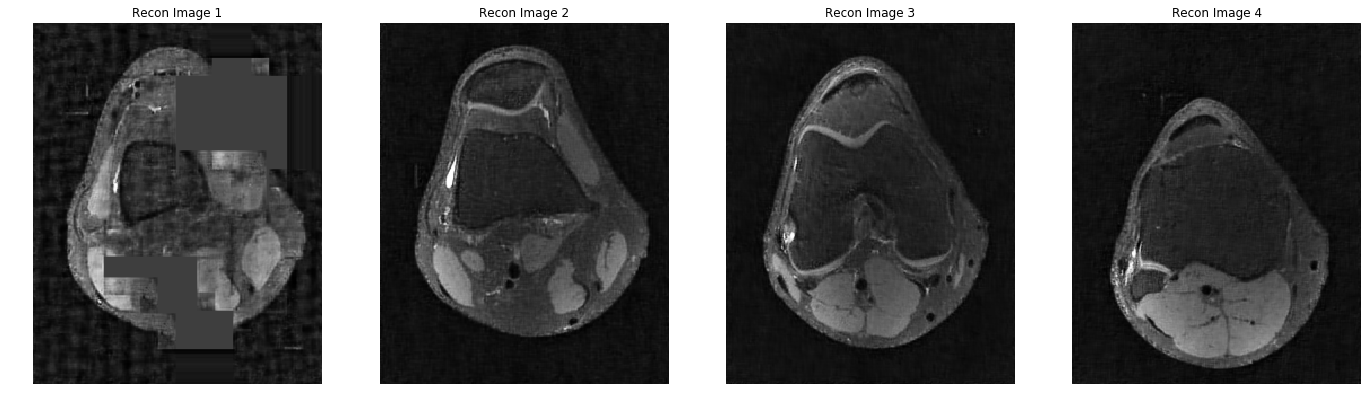

L1 errors:  [0.13720186486295147, 0.0601757208363634, 0.05331824363922707, 0.07839319877041719]
L2 errors:  [0.03221136498658693, 0.006498204778405343, 0.0056390005763628775, 0.009625317776842859]
Trial 1


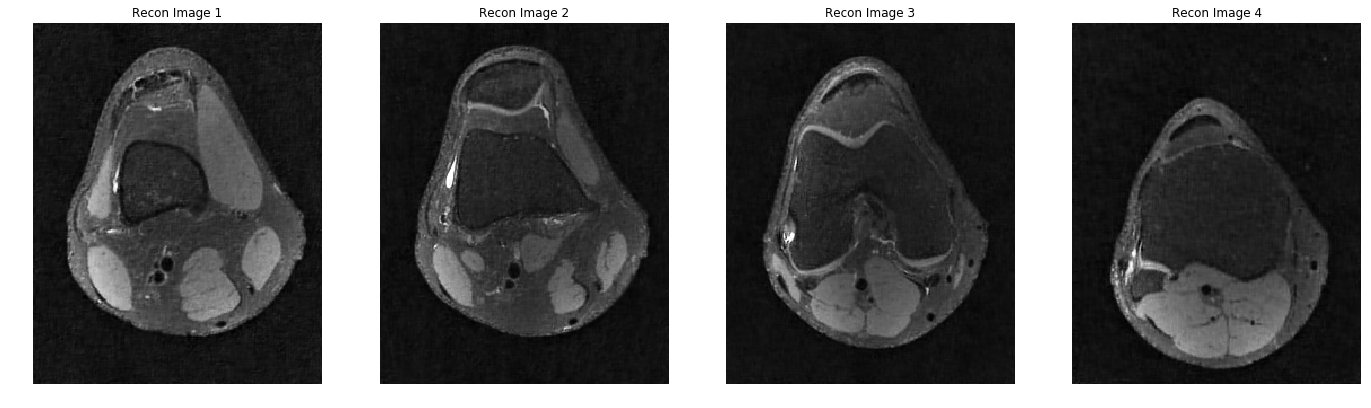

L1 errors:  [0.11941088370971686, 0.060119738512305086, 0.053405794824819205, 0.0787632683440829]
L2 errors:  [0.021629458482551954, 0.006457724570632628, 0.005633074692486431, 0.009835566001361613]
Trial 2


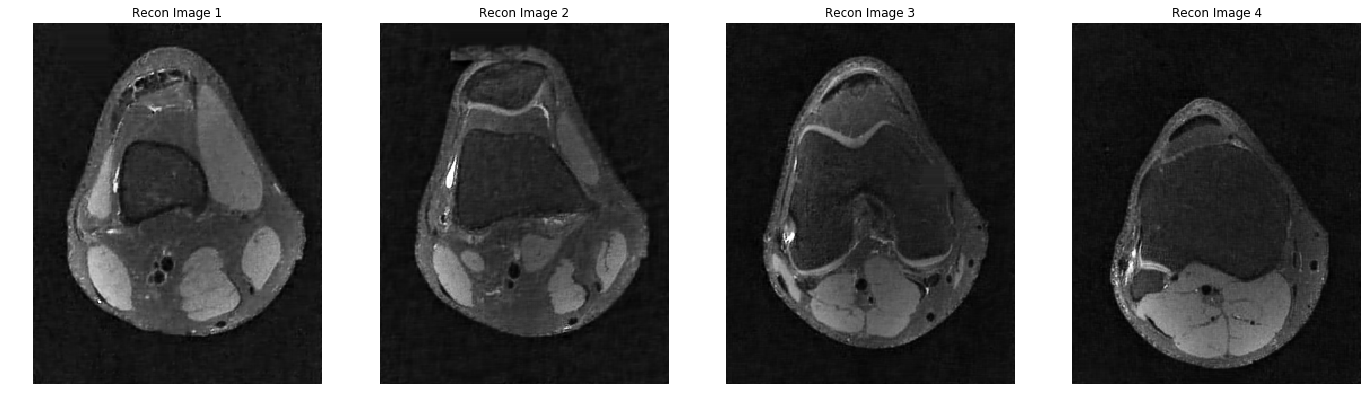

L1 errors:  [0.11895670604763993, 0.06203774024355484, 0.05389781234516176, 0.07825705457774783]
L2 errors:  [0.02150381115354234, 0.0071051529511990934, 0.005709422373383963, 0.009446722845145767]


In [64]:
# compare L1 loss, same image init, jitters, 2x subsampling recon on different images

all_results = np.load('../deep_prior_data/comparisons/diff_images_L1.npy')
trials = 3
titles = ['Recon Image 1', 'Recon Image 2', 'Recon Image 3', 'Recon Image 4']
plt.figure(figsize=(30,10))
plt.subplot(151); plt.axis('off'); plt.title('Ground Truth Image 1'); plt.imshow(get_image_normalized(70)[:, :, 0], cmap='gray')
plt.subplot(152); plt.axis('off'); plt.title('Ground Truth Image 2'); plt.imshow(get_image_normalized(100)[:, :, 0], cmap='gray')
plt.subplot(153); plt.axis('off'); plt.title('Ground Truth Image 3'); plt.imshow(get_image_normalized(170)[:, :, 0], cmap='gray')
plt.subplot(154); plt.axis('off'); plt.title('Ground Truth Image 4'); plt.imshow(get_image_normalized(240)[:, :, 0], cmap='gray')
plt.show()
print('Reconstructions: ')
for i in range(trials): # did 3 different noise values
    curr_L1 = []
    curr_L2 = []
    plt.figure(figsize=(30,10))
    #plt.subplot(151); plt.axis('off'); plt.title('Ground Truth'); plt.imshow(orig_img[:, :, 0], cmap='gray')
    print('Trial {}'.format(i))
    for j in range(4): # tested 4 diff images
        curr = all_results[j][i]
        best, ind = get_best_L2(curr[0], orig_img)
        plt.subplot(151 + j); plt.axis('off'); plt.title(titles[j]); plt.imshow(best[:, :, 0], cmap='gray')
        curr_L1.append(curr[1][0][ind])
        curr_L2.append(curr[1][1][ind])
    plt.show()
    print('L1 errors: ', curr_L1)
    print('L2 errors: ', curr_L2)

In [33]:
def get_best_L2(all_ims, compare):
    min_mse, best = np.float('inf'), all_ims[0]
    best_index = 0
    for index in range(1, len(all_ims)):
        img = all_ims[index]
        mse = np.mean(np.square(img[:, :, 0] - compare[:, :, 0]))
        if mse < min_mse:
            min_mse = mse
            best = img
            best_index = index
    best_index -= 1 # bc first index in images is the noise
    #print(best_index, min_mse)
    return best, best_index

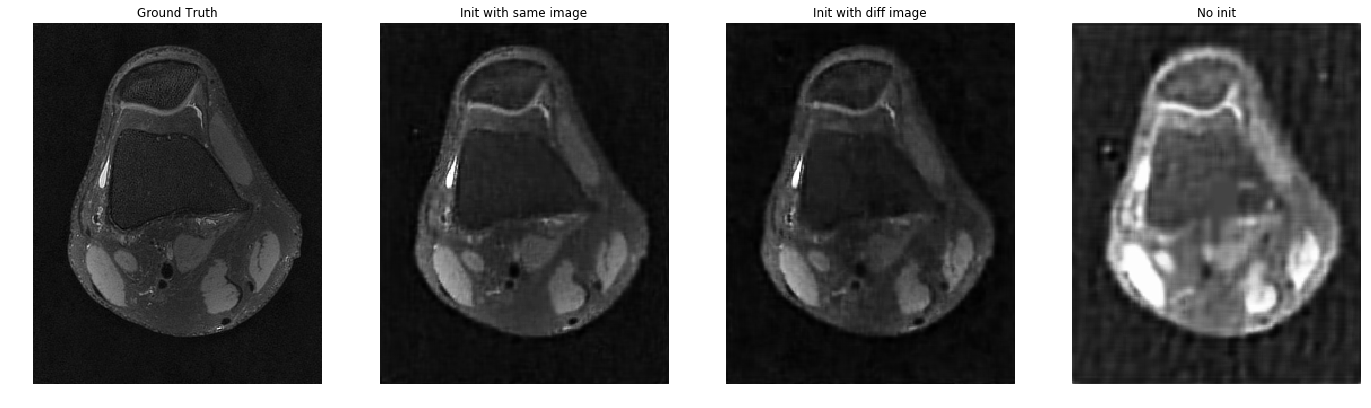

L1 errors:  [0.049729671919179354, 0.04008332969181707, 0.05922931807454335]
L2 errors:  [0.005133766992617467, 0.0034833669695894633, 0.007522650359963147]


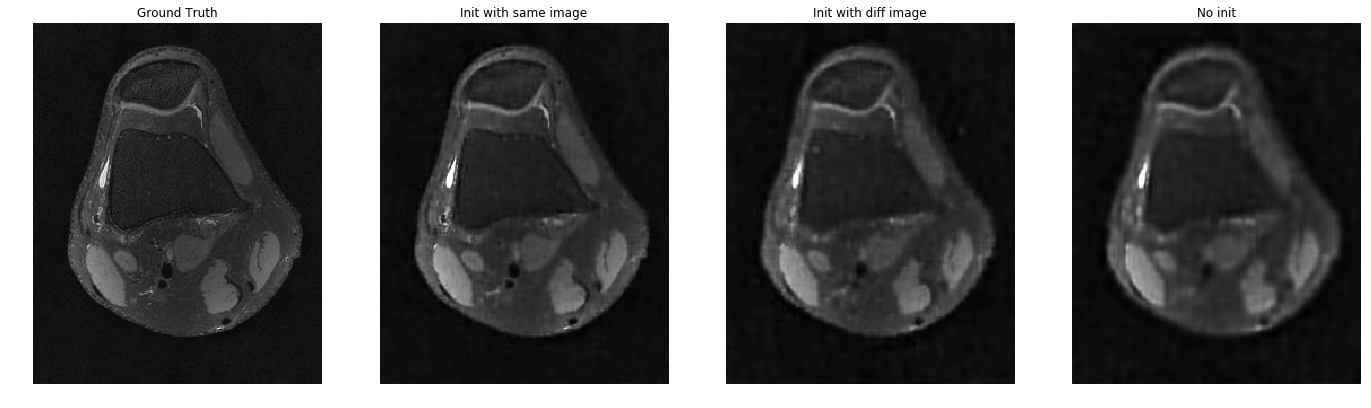

L1 errors:  [0.04950747099473459, 0.05372328087757676, 0.05225505717701201]
L2 errors:  [0.004883899324870442, 0.0057911557073805535, 0.0060056656925155175]


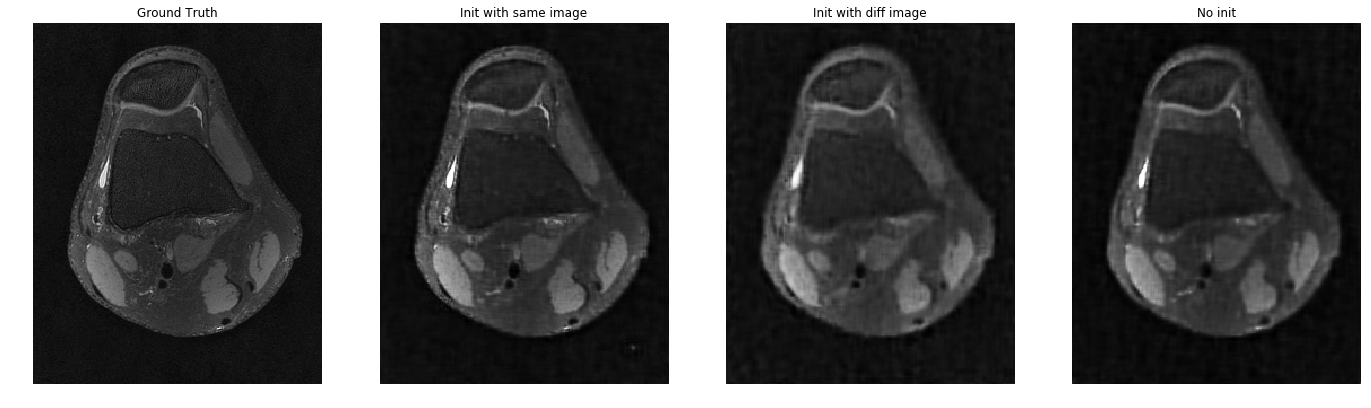

L1 errors:  [0.04710152872267449, 0.05494978417905255, 0.05167933481336321]
L2 errors:  [0.0046962114671906105, 0.006263210171626799, 0.005445817845716371]


In [34]:
# compare init with same image, init with diff image, no init: L2 loss + jittering for recon 2x subs
# show image comparisons at same noise input, graph of error

all_results = np.load('../deep_prior_data/comparisons/diff_inits_L2.npy')
same_init = all_results[0]
diff_init = all_results[1]
no_init = all_results[2]
np.shape(same_init[0][0])
trials = 3
titles = ['Init with same image', 'Init with diff image', 'No init']
for i in range(trials): # did 3 different noise values
    curr_L1 = []
    curr_L2 = []
    plt.figure(figsize=(30,10))
    
    plt.subplot(151); plt.axis('off'); plt.title('Ground Truth'); plt.imshow(orig_img[:, :, 0], cmap='gray')
    
    for j in range(3): # tested 3 diff options
        curr = all_results[j][i]
        best, ind = get_best_L2(curr[0], orig_img)
        plt.subplot(152 + j); plt.axis('off'); plt.title(titles[j]); plt.imshow(best[:, :, 0], cmap='gray')
        curr_L1.append(curr[1][0][ind])
        curr_L2.append(curr[1][1][ind])
    plt.show()
    print('L1 errors: ', curr_L1)
    print('L2 errors: ', curr_L2)

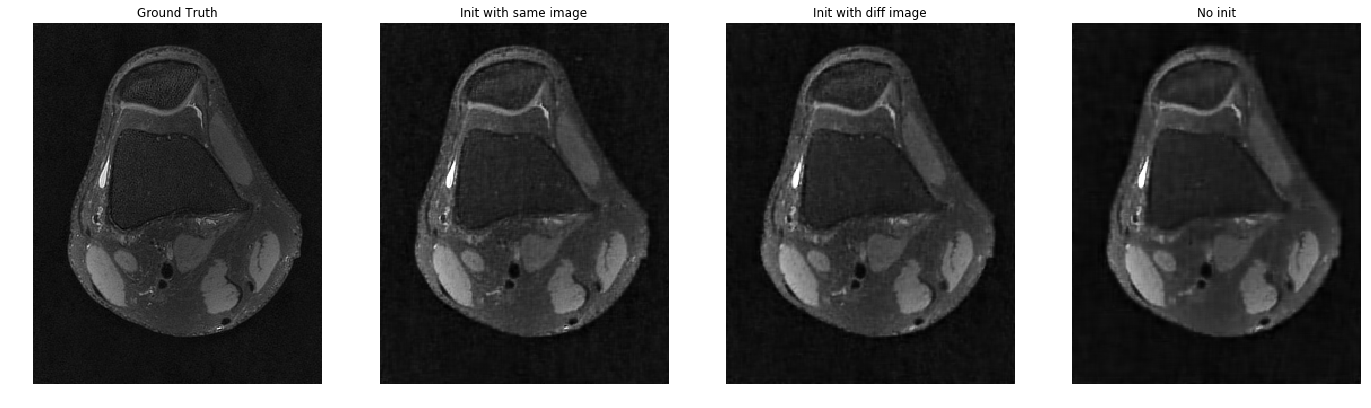

L1 errors:  [0.055998829217500726, 0.05580428000207952, 0.056013447895155145]
L2 errors:  [0.005823508996973767, 0.005982858967058218, 0.0061214708674197605]


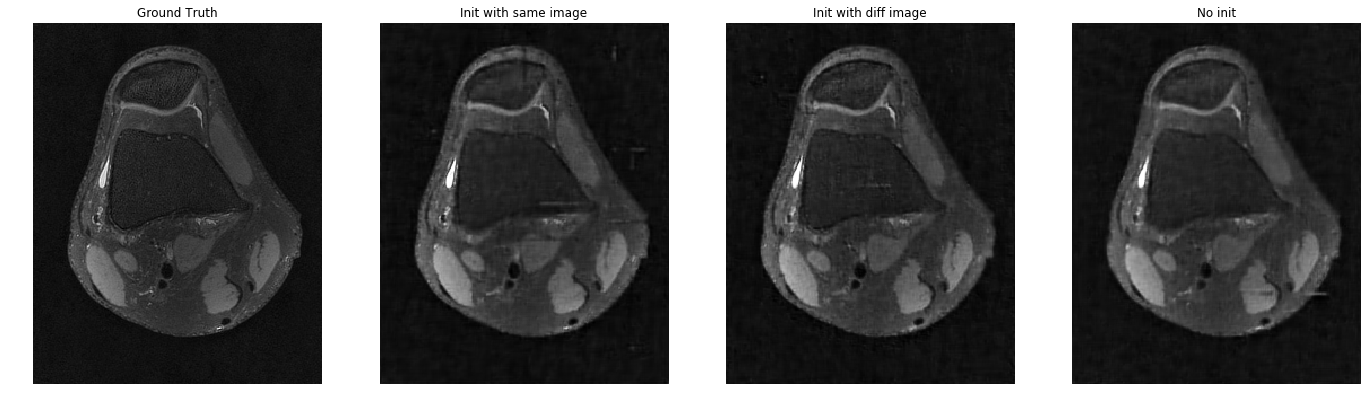

L1 errors:  [0.05393181426087599, 0.056139152461848064, 0.05297279386884143]
L2 errors:  [0.005713349215422891, 0.006027942944928328, 0.005652051960041334]


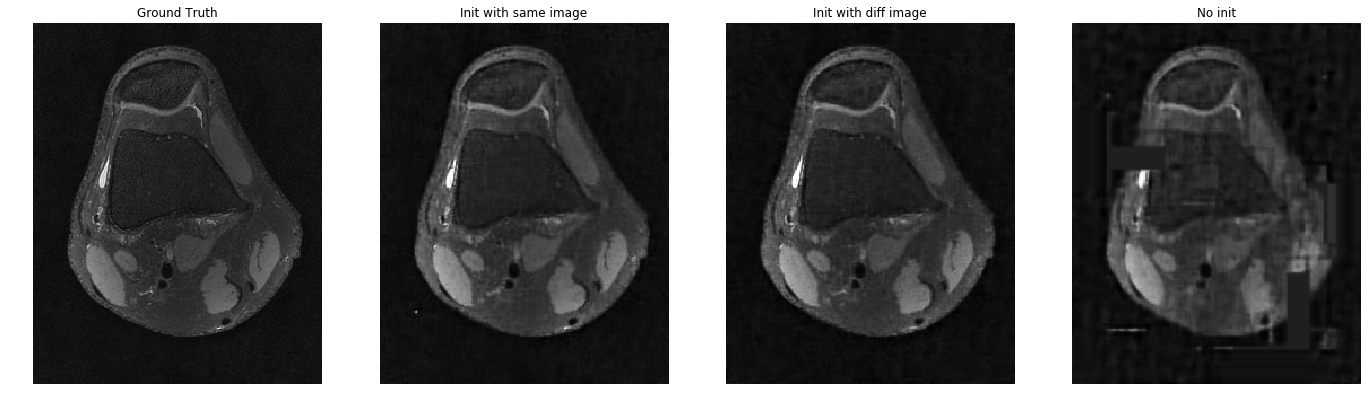

L1 errors:  [0.0532775587209135, 0.05468436291104297, 0.06552407392817743]
L2 errors:  [0.0056602165835799665, 0.005694186000860987, 0.009525472132927617]


In [35]:
# compare init with same image, init with diff image, no init: L1 loss + jittering for recon 2x subs
# show image comparisons at same noise input, graph of error

all_results = np.load('../deep_prior_data/comparisons/diff_inits_L1.npy')
same_init = all_results[0]
diff_init = all_results[1]
no_init = all_results[2]
np.shape(same_init[0][0])
trials = 3
titles = ['Init with same image', 'Init with diff image', 'No init']
for i in range(trials): # did 3 different noise values
    curr_L1 = []
    curr_L2 = []
    plt.figure(figsize=(30,10))
    plt.subplot(151); plt.axis('off'); plt.title('Ground Truth'); plt.imshow(orig_img[:, :, 0], cmap='gray')
    
    for j in range(3): # tested 3 diff options
        curr = all_results[j][i]
        best, ind = get_best_L2(curr[0], orig_img)
        plt.subplot(152 + j); plt.axis('off'); plt.title(titles[j]); plt.imshow(best[:, :, 0], cmap='gray')
        curr_L1.append(curr[1][0][ind])
        curr_L2.append(curr[1][1][ind])
    plt.show()
    print('L1 errors: ', curr_L1)
    print('L2 errors: ', curr_L2)

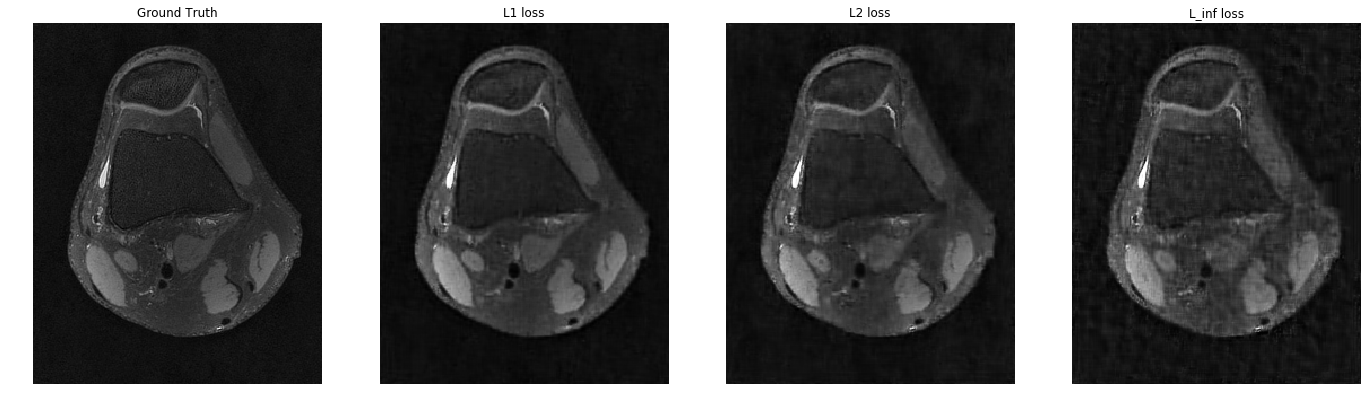

L1 errors:  [0.0528768987922835, 0.05333949015891233, 0.059334299438768015]
L2 errors:  [0.005485104085895387, 0.005534631048412774, 0.006682349741057636]


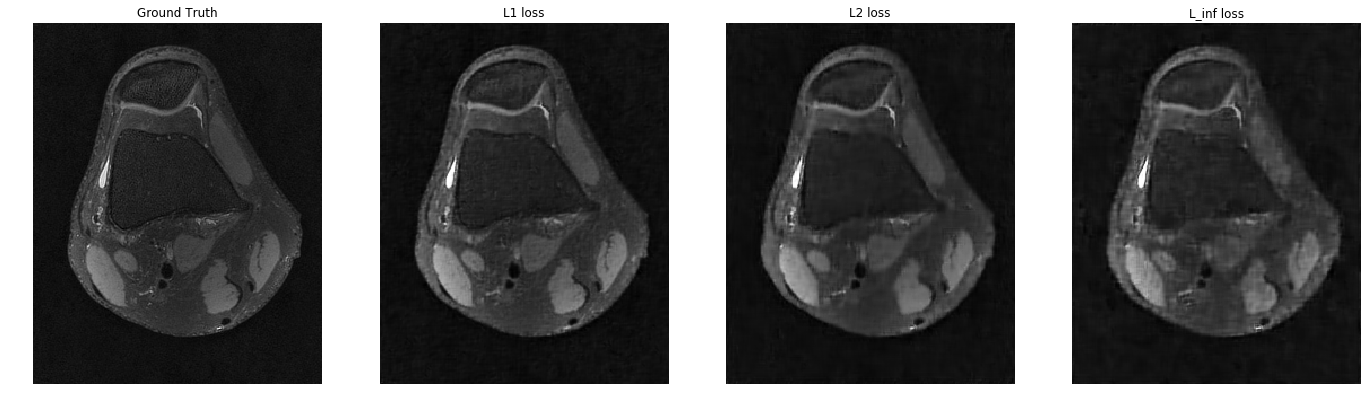

L1 errors:  [0.05306568498727845, 0.04467690727267531, 0.053269540284136475]
L2 errors:  [0.0054524125236582125, 0.004274535256021977, 0.0057777493953247985]


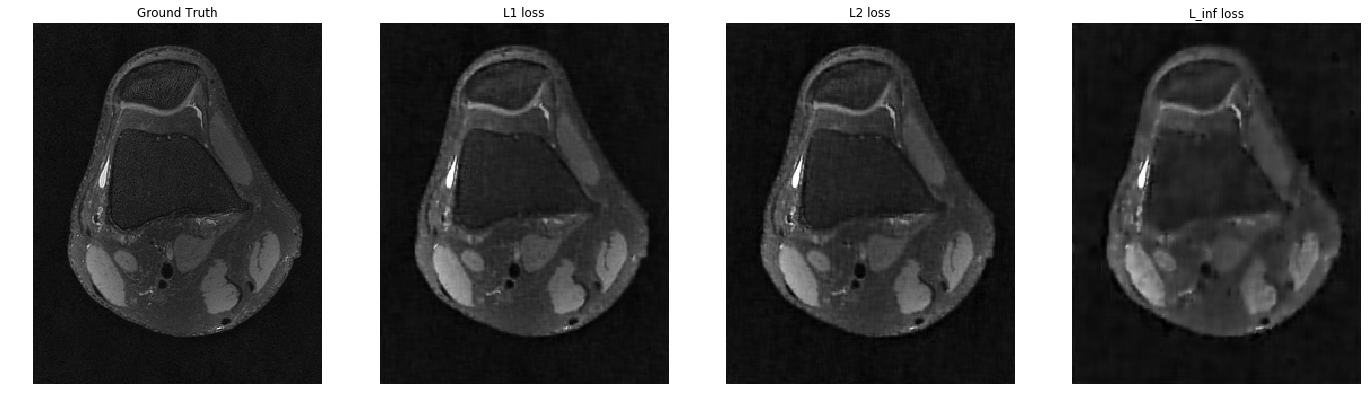

L1 errors:  [0.052458068143349, 0.04889058359217313, 0.056713252650738497]
L2 errors:  [0.00547634071164616, 0.0047594821622305074, 0.006286867691245333]


In [36]:
# compare L1 (init with L1 with same image), L2 (init with L2 same image), L_inf (init with L2 same image) loss,
# jitter sched: (0.1 for half, 0.01 for half)

all_results = np.load('../deep_prior_data/comparisons/diff_losses_inits.npy')
trials = 3
titles = ['L1 loss', 'L2 loss', 'L_inf loss']
for i in range(trials): # did 3 different noise values
    curr_L1 = []
    curr_L2 = []
    plt.figure(figsize=(30,10))
    plt.subplot(151); plt.axis('off'); plt.title('Ground Truth'); plt.imshow(orig_img[:, :, 0], cmap='gray')
    
    for j in range(3): # tested 3 diff options
        curr = all_results[j][i]
        best, ind = get_best_L2(curr[0], orig_img)
        plt.subplot(152 + j); plt.axis('off'); plt.title(titles[j]); plt.imshow(best[:, :, 0], cmap='gray')
        curr_L1.append(curr[1][0][ind])
        curr_L2.append(curr[1][1][ind])
    plt.show()
    print('L1 errors: ', curr_L1)
    print('L2 errors: ', curr_L2)

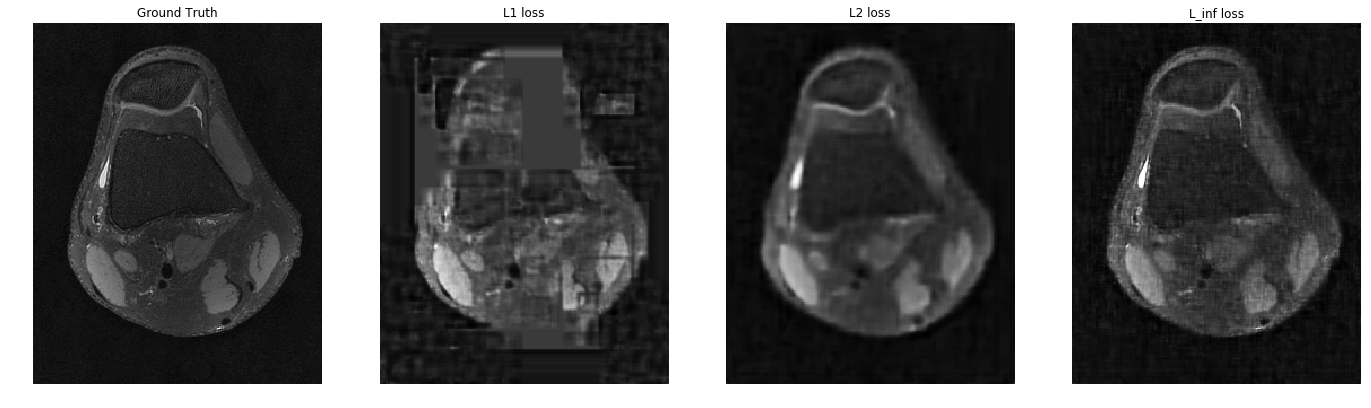

L1 errors:  [0.0799833688278917, 0.05248366382254571, 0.05922672810764932]
L2 errors:  [0.013934242982929588, 0.005962359260112277, 0.0068255637535022005]


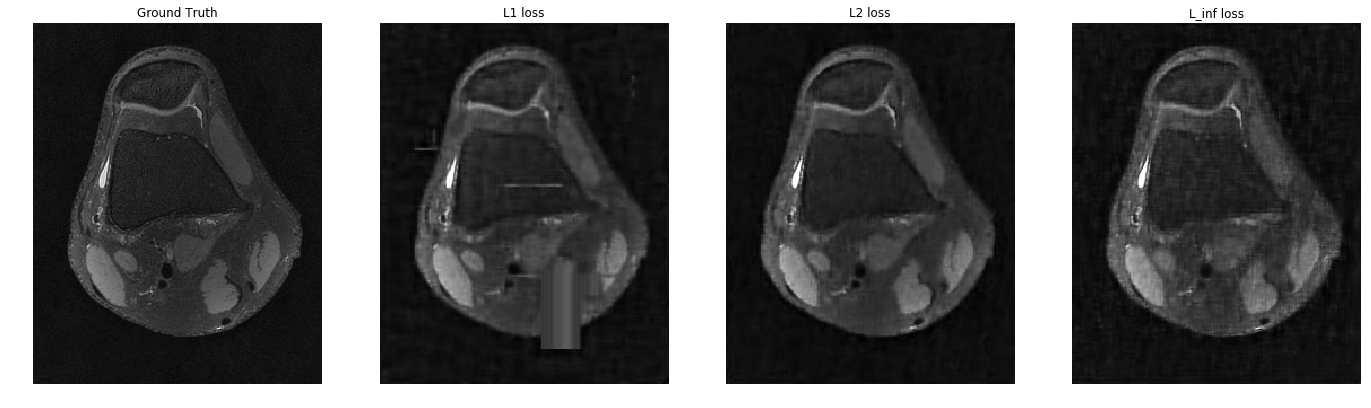

L1 errors:  [0.06027695968799115, 0.051796939167506606, 0.057117303982524195]
L2 errors:  [0.008034064311979795, 0.005470921103633843, 0.006521886147872029]


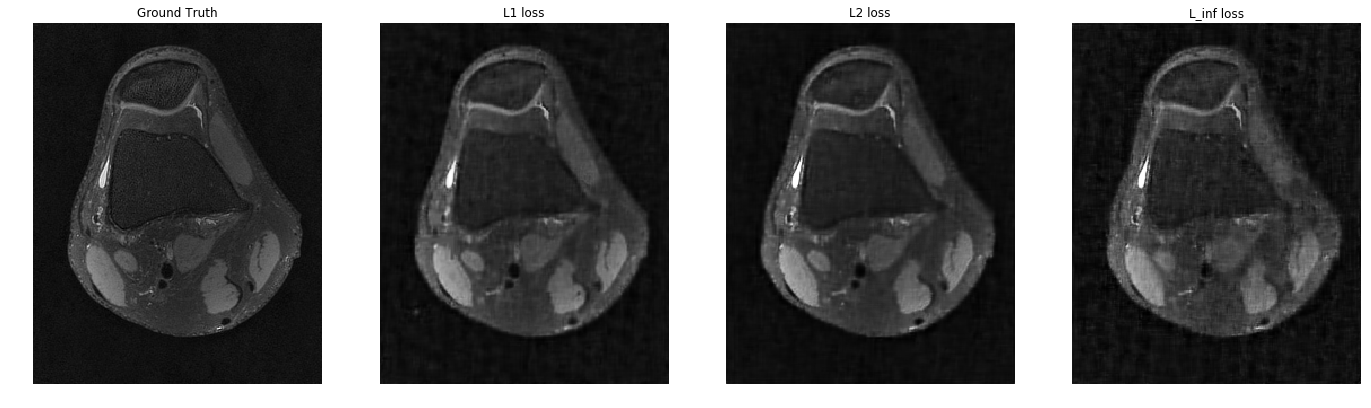

L1 errors:  [0.056654861632515485, 0.051530599965096666, 0.06056346595830495]
L2 errors:  [0.0062202595403444035, 0.005500481802323069, 0.006891282930118614]


In [37]:
# compare L1, L2, L_inf loss with decay jittering sched, no init
# jitter sched: (0.1 for half, 0.01 for half)

all_results = np.load('../deep_prior_data/comparisons/diff_losses_noinit1.npy')
trials = 3
titles = ['L1 loss', 'L2 loss', 'L_inf loss']
for i in range(trials): # did 3 different noise values
    curr_L1 = []
    curr_L2 = []
    plt.figure(figsize=(30,10))
    plt.subplot(151); plt.axis('off'); plt.title('Ground Truth'); plt.imshow(orig_img[:, :, 0], cmap='gray')
    
    for j in range(3): # tested 3 diff options
        curr = all_results[j][i]
        best, ind = get_best_L2(curr[0], orig_img)
        plt.subplot(152 + j); plt.axis('off'); plt.title(titles[j]); plt.imshow(best[:, :, 0], cmap='gray')
        curr_L1.append(curr[1][0][ind])
        curr_L2.append(curr[1][1][ind])
    plt.show()
    print('L1 errors: ', curr_L1)
    print('L2 errors: ', curr_L2)

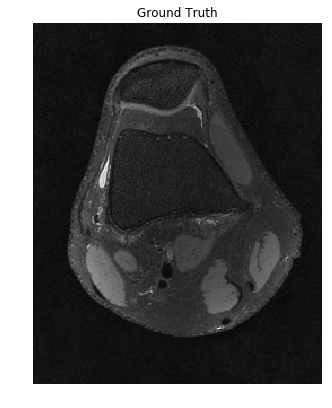

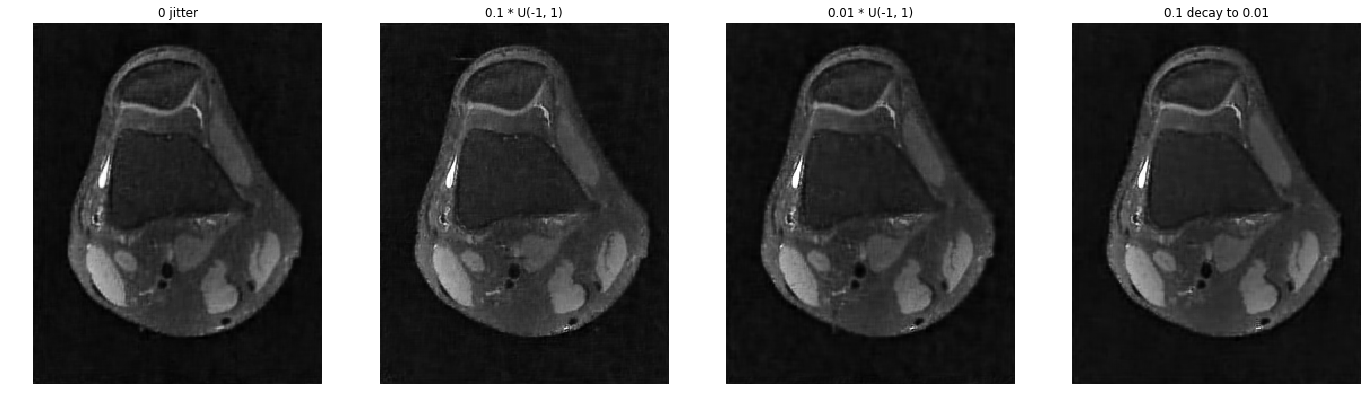

L1 errors:  [0.04604623919734156, 0.05342855383709407, 0.04296630279237663, 0.04910022523073869]
L2 errors:  [0.004427206967990746, 0.005629439682347836, 0.0038314662843056324, 0.004754847976171981]


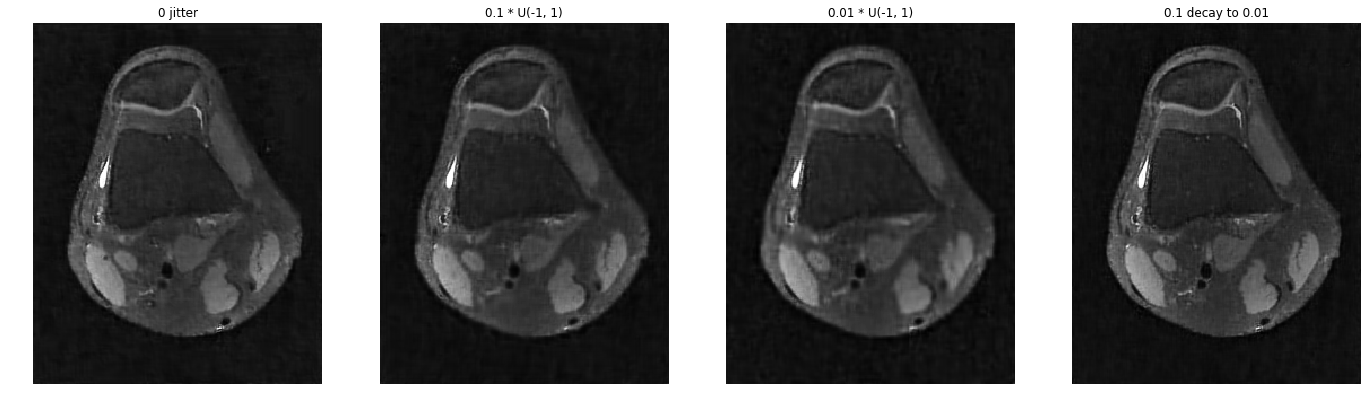

L1 errors:  [0.052158732379391934, 0.0448525744150746, 0.05141535573389968, 0.04991317144529912]
L2 errors:  [0.005189765501845201, 0.004198503794201404, 0.005246805807474687, 0.00496907090389955]


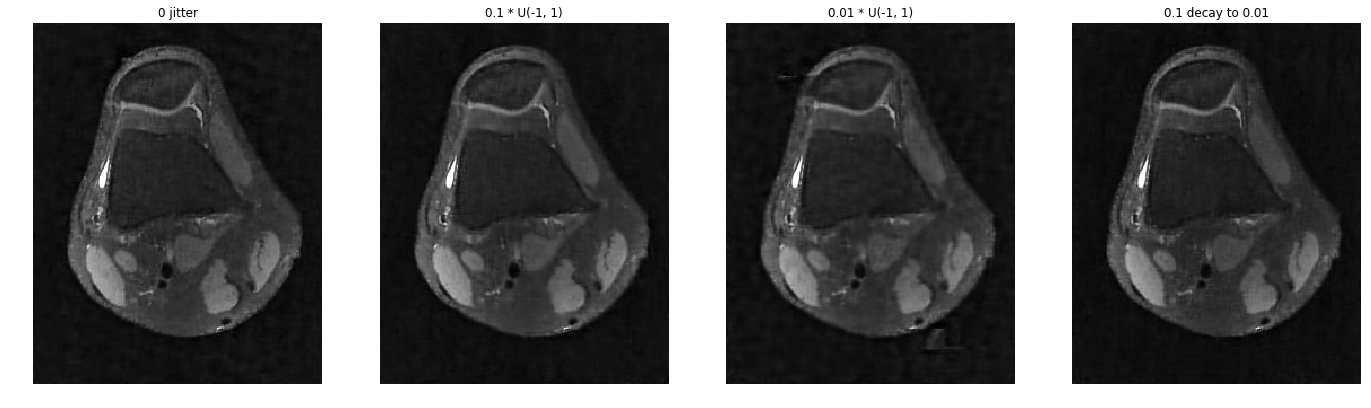

L1 errors:  [0.05435542969097579, 0.05236829881610766, 0.04494524213953095, 0.03570158340458788]
L2 errors:  [0.0056910255874863674, 0.005379548033281366, 0.00429283871085997, 0.002754791083393086]


In [38]:
# compare jittering schedule for init with same image, L2 loss
# 0 jitter, 0.1, 0.01, 0.1/0.01 decay

all_results = np.load('../deep_prior_data/comparisons/diff_jittering_L2.npy')
trials = 3
titles = ['0 jitter', '0.1 * U(-1, 1)', '0.01 * U(-1, 1)', '0.1 decay to 0.01']
plt.figure(figsize=(30,10))
plt.subplot(151); plt.axis('off'); plt.title('Ground Truth'); plt.imshow(orig_img[:, :, 0], cmap='gray')
for i in range(trials): # did 3 different noise values
    curr_L1 = []
    curr_L2 = []
    plt.figure(figsize=(30,10))
    #plt.subplot(151); plt.axis('off'); plt.title('Ground Truth'); plt.imshow(orig_img[:, :, 0], cmap='gray')
    
    for j in range(4): # tested 4 diff options
        curr = all_results[j][i]
        best, ind = get_best_L2(curr[0], orig_img)
        plt.subplot(151 + j); plt.axis('off'); plt.title(titles[j]); plt.imshow(best[:, :, 0], cmap='gray')
        curr_L1.append(curr[1][0][ind])
        curr_L2.append(curr[1][1][ind])
    plt.show()
    print('L1 errors: ', curr_L1)
    print('L2 errors: ', curr_L2)

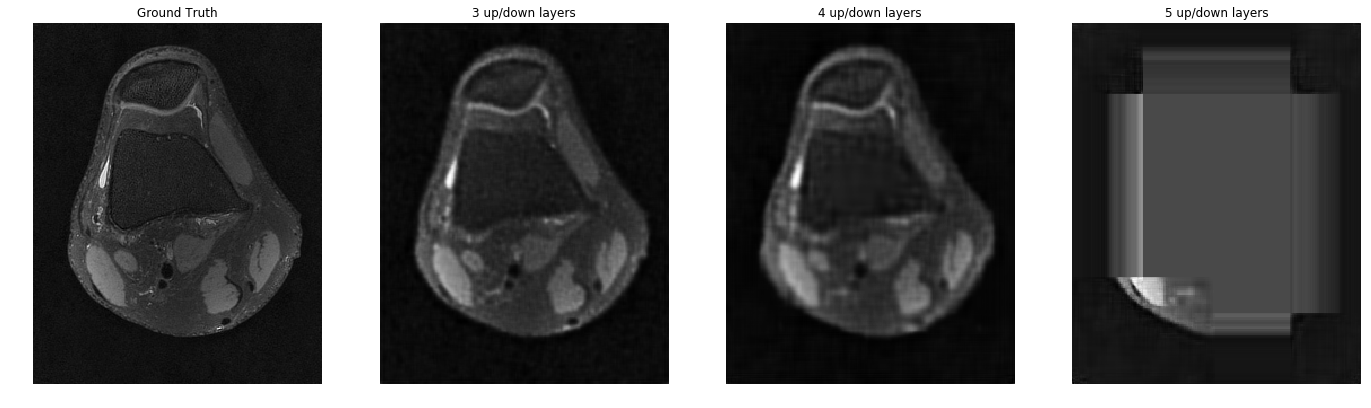

L1 errors:  [0.03256109434925392, 0.03531677669915785, 0.08623886792873726]
L2 errors:  [0.002482613051392956, 0.0031818247424896828, 0.019135939908403333]


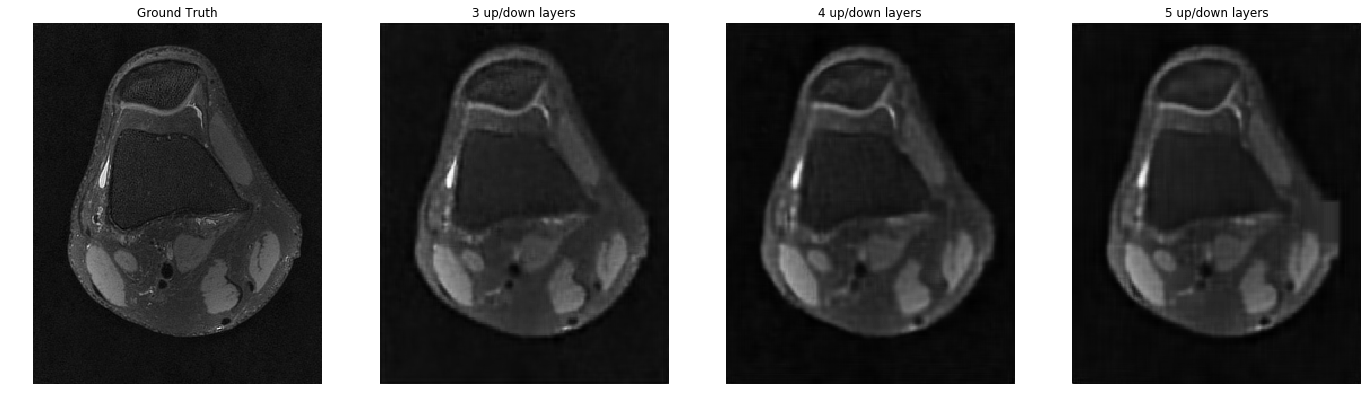

L1 errors:  [0.0312916007633804, 0.03319702332680662, 0.032649045571120645]
L2 errors:  [0.0022396638196145193, 0.002671380443651904, 0.0026417748832444307]


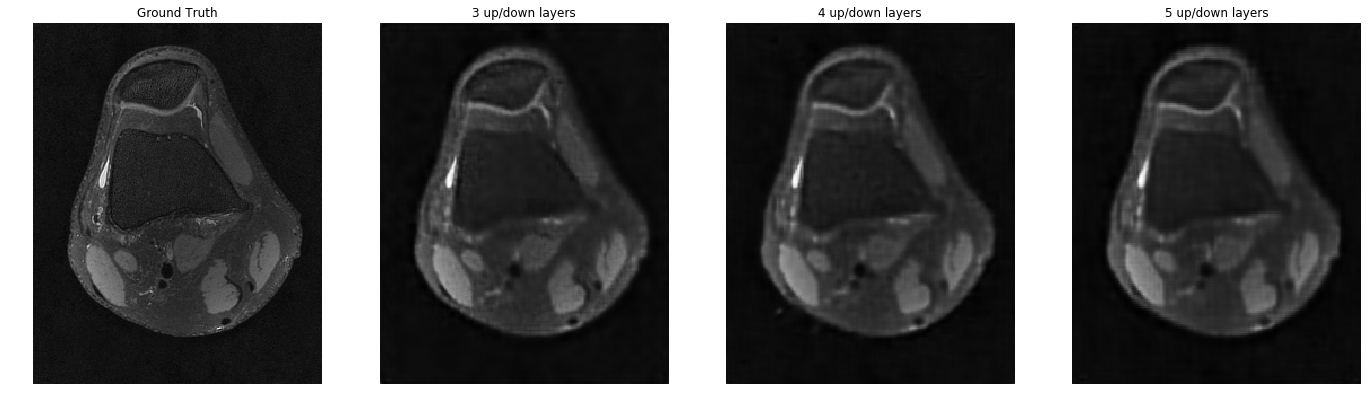

L1 errors:  [0.031648411664999064, 0.03305099915947487, 0.03279883735003307]
L2 errors:  [0.002285712418143771, 0.002571131005522608, 0.002618755543612095]


In [39]:
# compare different network sizes

all_results = np.load('../deep_prior_data/comparisons/diff_networks_full.npy')
trials = 3
titles = ['3 up/down layers', '4 up/down layers', '5 up/down layers']
for i in range(trials): # did 3 different networks
    curr_L1 = []
    curr_L2 = []
    plt.figure(figsize=(30,10))
    plt.subplot(151); plt.axis('off'); plt.title('Ground Truth'); plt.imshow(orig_img[:, :, 0], cmap='gray')
    
    for j in range(3): # tested 3 diff options
        curr = all_results[j][i]
        best, ind = get_best_L2(curr[0], orig_img)
        plt.subplot(152 + j); plt.axis('off'); plt.title(titles[j]); plt.imshow(best[:, :, 0], cmap='gray')
        curr_L1.append(curr[1][0][ind])
        curr_L2.append(curr[1][1][ind])
    plt.show()
    print('L1 errors: ', curr_L1)
    print('L2 errors: ', curr_L2)

In [25]:
import sigpy as sp
import sigpy.mri as mr

imgs = [subs_img, subs_img_4, subs_img_6]
res = []
for subs in imgs:

    img = subs[:, :, 0].astype(np.complex)
    ksp = sp.fft.fft(img)
    lamda = 0.00001
    W = sp.linop.Wavelet(img.shape)
    proxg = sp.prox.UnitaryTransform(sp.prox.L1Reg(W.oshape, lamda), W)
    A = sp.linop.FFT(img.shape)
    img_l1wav = np.zeros_like(img)
    img_l1wav = sp.app.LinearLeastSquares(A, ksp, img_l1wav, proxg=proxg).run()
    res.append(img_l1wav)

c:\users\jains\appdata\local\programs\python\python36\lib\site-packages\pywt\_multilevel.py:664: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  coeff_arr[a_slices] = a_coeffs
c:\users\jains\appdata\local\programs\python\python36\lib\site-packages\pywt\_multilevel.py:690: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  coeff_arr[slice_array] = d

GradientMethod:   0%|                                                                          | 0/100 [00:00<?, ?it/s]c:\users\jains\appdata\local\programs\python\python36\lib\site-packages\pywt\_mu

GradientMethod:  78%|██████████████████████████████████████▏          | 78/100 [00:03<00:00, 24.18it/s, resid=1.23e-13]


GradientMethod:  18%|████████▊                                        | 18/100 [00:00<00:03, 26.58it/s, resid=1.22e-13]


GradientMethod:  69%|█████████████████████████████████▊               | 69/100 [00:02<00:01, 26.82it/s, resid=1.23e-13]


GradientMethod:   9%|████▌                                             | 9/100 [00:00<00:03, 26.03it/s, resid=1.19e-13]


GradientMethod:  60%|█████████████████████████████▍                   | 60/100 [00:02<00:01, 26.81it/s, resid=1.21e-13]


GradientMethod: 100%|████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.38it/s, resid=1.24e-13]

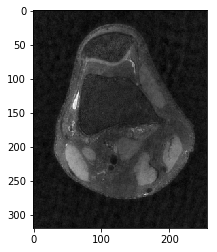

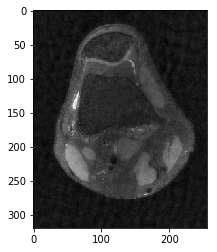

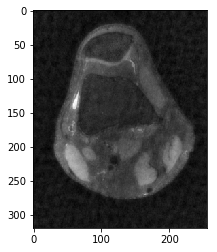

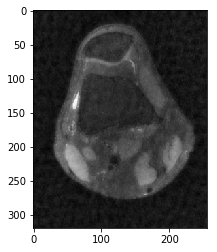

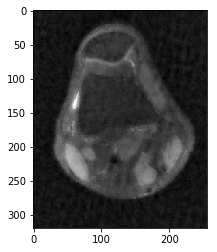

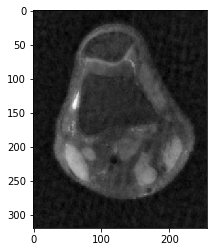

In [26]:
for im, r in zip(imgs, res):
    plt.imshow(im[:, :, 0], cmap='gray')
    plt.show()
    plt.imshow(np.real(r), cmap='gray')
    plt.show()
#print(np.max((imgs[-1][:, :, 0] - np.real(res[-1]))))